In [33]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [34]:
# 2. Đọc file csv và gắng index với Close
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GBPUSDX.csv')
df = df.dropna()
df=df.reset_index()['Close']


In [35]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [36]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [37]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [38]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [39]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [40]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [41]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 39ms/step - loss: 0.0568 - val_loss: 0.0081
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0031 - val_loss: 0.0136
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0017 - val_loss: 0.0128
Epoch 5/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0015 - val_loss: 0.0099
Epoch 6/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0084
Epoch 7/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0074
Epoch 8/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 9/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 10/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0052

In [42]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 10ms/step


In [43]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [44]:
# Chia train test lại
train_data1 = df[:train_size]
test_data1 = df[train_size:train_size+test_size]
val_data1 = df[train_size+test_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [45]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 0.03340122705076929
Testing RMSE: 0.0687302629913351
Validation MAPE: 2.261608808353206
Testing MAPE: 4.7449521635871665
Validation MAE: 0.02743039910026669
Testing MAE: 0.05724562178498399


In [46]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[43:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.46445724 0.45710634 0.44312938 0.46616148 0.4669306  0.46278897
 0.44987163 0.43750207 0.45995042 0.41373682 0.3645325  0.35944192
 0.36714142 0.37181147 0.38435809 0.36649956 0.39413255 0.40027445
 0.36304682 0.34521596 0.36028297 0.36288636 0.38228589 0.36585494
 0.35696303 0.3388804  0.36907252 0.36132322 0.3603217  0.33864248
 0.35992054 0.35936169 0.30438343 0.31058896 0.33059991 0.37399157
 0.39945276 0.39413255 0.37120835 0.38261235 0.40396789 0.42847183
 0.41431504 0.42943185 0.42993261 0.42010004 0.43436196 0.44346691
 0.43880239 0.45918684 0.43143488 0.46910516 0.48994057 0.48015781
 0.47349579 0.47145679 0.46054525 0.47128526 0.48834147 0.49737171
 0.46275577 0.45591946 0.46974702 0.47068767 0.47402421 0.47646437
 0.49037217 0.46680057 0.482479   0.48968051 0.50631066 0.48648507
 0.48390104 0.50945354 0.5134347  0.52649591 0.52156026 0.52486361
 0.52550823 0.49262143 0.47680743 0.49734681 0.48605347 0.48561635
 0.46611998 0.47959895 0.47222591 0.46748393 0.454

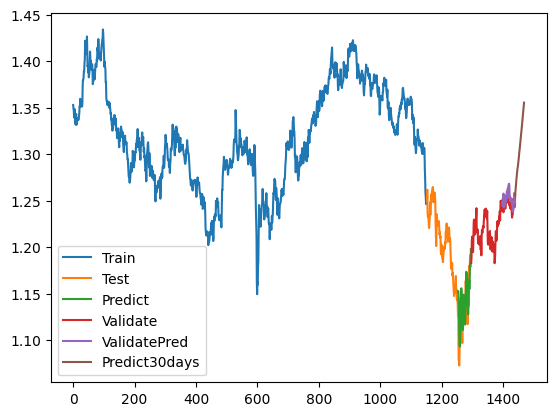

In [47]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()